In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
df = pd.read_csv("../../dataset/df_cleaned_1atc.tsv", sep="\t")
df["drug_era_start_date"] = pd.to_datetime(df["drug_era_start_date"])
df["drug_era_end_date"] = pd.to_datetime(df["drug_era_end_date"])
df_n06a = (
    df[df["atc_level3"] == "N06A"]
    .sort_values(by=["eid", "drug_era_start_date"])
    .reset_index(drop=True)
)
df_n06a.head()

,eid,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code,duration,atc_level3
0,1000014,128849065239,710062,2010-02-15,2010-02-26,2,0,amitriptyline,N06AA09,12,N06A
1,1000014,1245540543307,710062,2010-04-23,2010-04-30,1,0,amitriptyline,N06AA09,8,N06A
2,1000014,670014960364,710062,2010-06-25,2010-07-02,1,0,amitriptyline,N06AA09,8,N06A
3,1000014,1228360666726,710062,2014-03-10,2014-03-17,1,0,amitriptyline,N06AA09,8,N06A
4,1000041,661424994579,797617,2014-02-14,2014-02-27,1,0,citalopram,N06AB04,14,N06A


In [5]:
len(np.unique(df_n06a["eid"]))

69066

In [10]:
# create a mapping for each atc_code to a number
atc_code_to_num = {
    atc_code: i + 1 for i, atc_code in enumerate(df_n06a["atc_code"].unique())
}
df_n06a["atc_code_num"] = df_n06a["atc_code"].map(atc_code_to_num)
df_n06a.head()

,eid,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code,duration,atc_level3,atc_code_num
0,1000014,128849065239,710062,2010-02-15,2010-02-26,2,0,amitriptyline,N06AA09,12,N06A,1
1,1000014,1245540543307,710062,2010-04-23,2010-04-30,1,0,amitriptyline,N06AA09,8,N06A,1
2,1000014,670014960364,710062,2010-06-25,2010-07-02,1,0,amitriptyline,N06AA09,8,N06A,1
3,1000014,1228360666726,710062,2014-03-10,2014-03-17,1,0,amitriptyline,N06AA09,8,N06A,1
4,1000041,661424994579,797617,2014-02-14,2014-02-27,1,0,citalopram,N06AB04,14,N06A,2


In [11]:
alphabet_size = len(atc_code_to_num) + 1
print(f"alphabet size: {alphabet_size}")

alphabet size: 10


In [12]:
# create sequences for each eid
def eid_to_sequence(eid_df: pd.DataFrame):
    # Sort by start date
    eid_df = eid_df.sort_values("drug_era_start_date").reset_index(drop=True)

    # Initialize sequence
    sequence = []
    for index, row in eid_df.iterrows():
        next_start_date = (
            eid_df["drug_era_start_date"].iloc[index + 1]
            if index != len(eid_df) - 1
            else pd.NaT
        )
        sequence.append(row["atc_code_num"])
        if (
            index != 0
            and index != len(eid_df) - 1
            and next_start_date - row["drug_era_end_date"] > pd.Timedelta(days=60)
        ):
            sequence.append(0)
    return sequence


eids = np.random.choice(df_n06a["eid"].unique(), 1000)
sequences = [eid_to_sequence(df_n06a[df_n06a["eid"] == eid]) for eid in eids]
sequence_lengths = [len(sequence) for sequence in sequences]

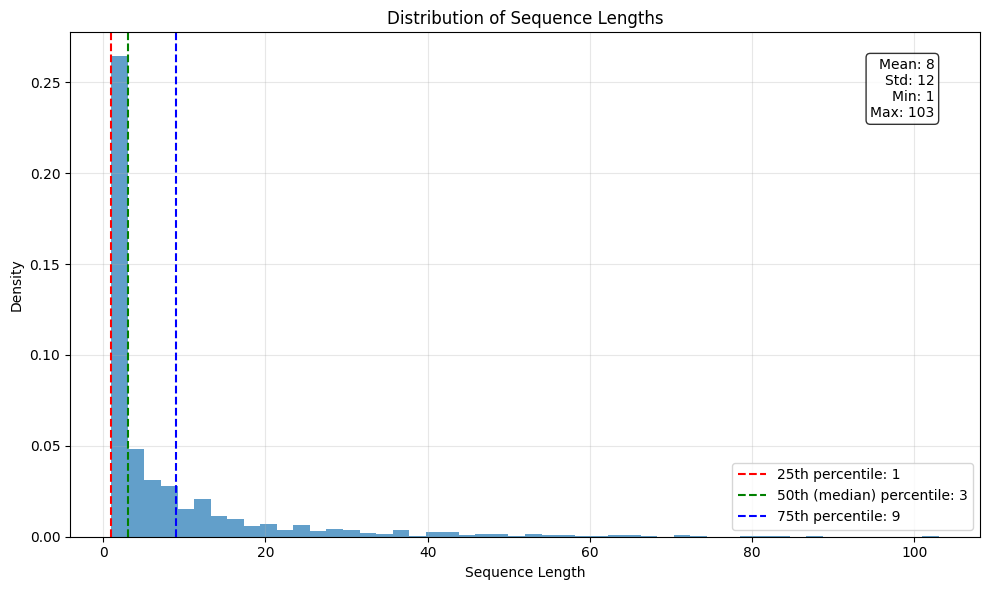

In [13]:
# Calculate quantiles
quantiles = [0.25, 0.5, 0.75]
q_values = np.quantile(sequence_lengths, quantiles)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histogram
n, bins, patches = plt.hist(sequence_lengths, bins=50, density=True, alpha=0.7)

# Add vertical lines for quantiles
colors = ["r", "g", "b"]
labels = ["25th", "50th (median)", "75th"]
for q, c, l in zip(q_values, colors, labels):  # noqa: E741
    plt.axvline(x=q, color=c, linestyle="--", label=f"{l} percentile: {int(q)}")

# Customize plot
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)

# Add text with statistics
stats_text = f"Mean: {int(np.mean(sequence_lengths))}\n"
stats_text += f"Std: {int(np.std(sequence_lengths))}\n"
stats_text += f"Min: {int(np.min(sequence_lengths))}\n"
stats_text += f"Max: {int(np.max(sequence_lengths))}"
plt.text(
    0.95,
    0.95,
    stats_text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

In [14]:
# keep only sequences within the 25th to 75th percentile
sequences = [
    sequence
    for sequence in sequences
    if len(sequence) >= int(q_values[0]) and len(sequence) <= int(q_values[2])
]

In [15]:
def sequence_similarity_score(seq1: list, seq2: list) -> int:
    """
    Calculate similarity score between two sequences based on their treatment periods.
    Each unique ending drug is only counted once.

    Scoring rules:
    - Same ending drug in a period: +3 points (counted once per unique ending)
    - Same drug before the ending: +1 point

    Args:
        seq1: First sequence of numbers
        seq2: Second sequence of numbers

    Returns:
        int: Similarity score
    """
    # Split sequences by 0 to get treatment periods
    periods1 = [period for period in "".join(map(str, seq1)).split("0") if period]
    periods2 = [period for period in "".join(map(str, seq2)).split("0") if period]

    total_score = 0
    counted_endings = set()  # Keep track of endings we've already counted

    # Compare each period from seq1 with each period from seq2
    for p1 in periods1:
        for p2 in periods2:
            # Convert back to integers
            p1_nums = [int(x) for x in p1]
            p2_nums = [int(x) for x in p2]

            # Check ending drugs (3 points)
            if p1_nums[-1] == p2_nums[-1]:
                # Only count this ending if we haven't seen it before
                if p1_nums[-1] not in counted_endings:
                    total_score += 3
                    counted_endings.add(p1_nums[-1])

                # Check drugs before ending
                min_len = min(len(p1_nums), len(p2_nums))
                if min_len > 1:
                    # Compare all positions before the last one
                    for i in range(min_len - 1):
                        if p1_nums[i] == p2_nums[i]:
                            total_score += 1

    return total_score


# Example usage:
sequence1 = sequences[10]
sequence2 = sequences[15]
score = sequence_similarity_score(sequence1, sequence2)
print(f"Sequences: {sequence1} and {sequence2}")
print(f"Similarity score: {score}")

Sequences: [1, 1, 0, 1] and [2, 5]
Similarity score: 0


In [34]:
# Example usage:
sequence1 = [5, 2, 0, 5, 3]
sequence2 = [7, 5, 3]
score = sequence_similarity_score(sequence1, sequence2)
print(f"Sequences: {sequence1} and {sequence2}")
print(f"Similarity score: {score}")

Sequences: [5, 2, 0, 5, 3] and [7, 5, 3]
Similarity score: 3


In [47]:
def create_distance_matrix(sequences: list) -> np.ndarray:
    """
    Create a distance matrix using similarity scores between all pairs of sequences.
    Converts similarity scores to distances for clustering.
    """
    n = len(sequences)
    dist_matrix = np.zeros((n, n))

    # First find the maximum possible similarity score to help with normalization
    max_similarity = 0
    for i in range(n):
        for j in range(i + 1, n):
            similarity = sequence_similarity_score(sequences[i], sequences[j])
            max_similarity = max(max_similarity, similarity)

    # Create distance matrix where distance = max_similarity - similarity
    for i in range(n):
        for j in range(i + 1, n):
            similarity = sequence_similarity_score(sequences[i], sequences[j])
            # Convert similarity to distance: higher similarity = lower distance
            distance = max_similarity - similarity
            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance

    return dist_matrix


def cluster_sequences(sequences: list, n_clusters: int = 5):
    """
    Cluster sequences using hierarchical clustering based on similarity scores

    Args:
        sequences: List of sequences to cluster
        n_clusters: Number of clusters
    """
    # Create distance matrix
    dist_matrix = create_distance_matrix(sequences)

    # Convert to condensed form required by linkage
    condensed_dist = squareform(dist_matrix)

    # Perform hierarchical clustering
    linkage_matrix = linkage(
        condensed_dist, method="average"
    )  # you can try 'single', 'complete', 'ward' etc.

    # Create clusters
    clusters = fcluster(linkage_matrix, n_clusters, criterion="maxclust")

    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix)
    plt.title("Hierarchical Clustering Dendrogram (Based on Similarity Scores)")
    plt.xlabel("Sequence Index")
    plt.ylabel("Distance (Inverse of Similarity)")
    plt.show()

    return clusters

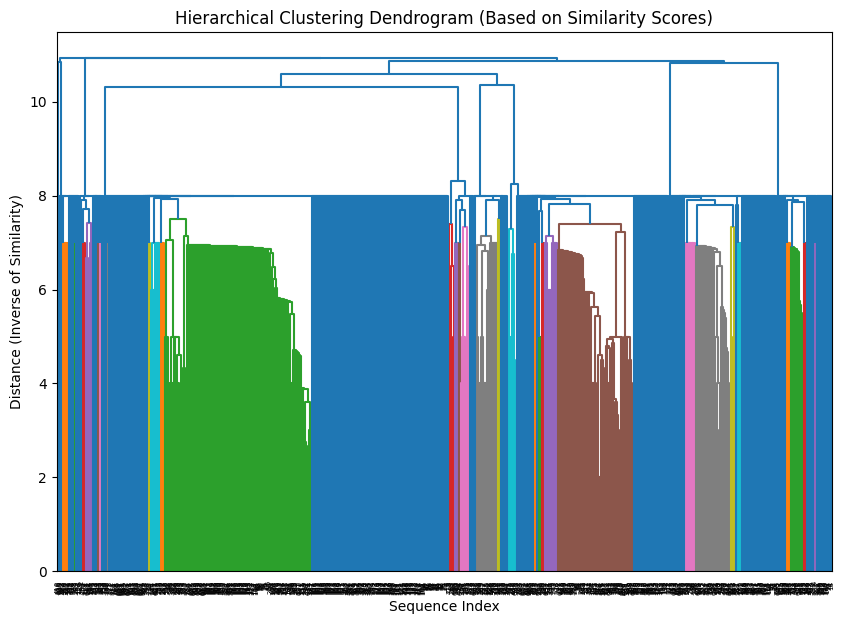


Cluster 1:
Number of sequences: 2
Average sequence length: 1.50
Length range: 1 - 2
Average pairwise similarity score: 3.00

Most common ending drugs:
  Drug 5: 2 times (100.0%)

Most common drugs used before ending:
  Drug 6: 1 times (100.0%)

Cluster 2:
Number of sequences: 20
Average sequence length: 2.35
Length range: 1 - 8
Average pairwise similarity score: 3.12

Most common ending drugs:
  Drug 6: 24 times (88.9%)
  Drug 7: 2 times (7.4%)
  Drug 5: 1 times (3.7%)

Most common drugs used before ending:
  Drug 6: 8 times (61.5%)
  Drug 7: 2 times (15.4%)
  Drug 1: 1 times (7.7%)

Cluster 3:
Number of sequences: 23
Average sequence length: 2.70
Length range: 1 - 8
Average pairwise similarity score: 3.16

Most common ending drugs:
  Drug 9: 23 times (100.0%)

Most common drugs used before ending:
  Drug 9: 21 times (53.8%)
  Drug 1: 7 times (17.9%)
  Drug 3: 6 times (15.4%)

Cluster 4:
Number of sequences: 336
Average sequence length: 2.53
Length range: 1 - 9
Average pairwise simila

In [53]:
def analyze_clusters(sequences: list, clusters: np.ndarray):
    """
    Analyze the characteristics of each cluster, including ending drugs
    and drugs used before ending
    """
    unique_clusters = np.unique(clusters)

    for cluster_id in unique_clusters:
        # Get sequences in this cluster
        cluster_indices = np.where(clusters == cluster_id)[0]
        cluster_sequences = [sequences[i] for i in cluster_indices]

        # Calculate basic statistics
        lengths = [len(seq) for seq in cluster_sequences]

        print(f"\nCluster {cluster_id}:")
        print(f"Number of sequences: {len(cluster_sequences)}")
        print(f"Average sequence length: {np.mean(lengths):.2f}")
        print(f"Length range: {min(lengths)} - {max(lengths)}")

        # Calculate average pairwise similarity within cluster
        if len(cluster_sequences) > 1:
            similarities = []
            for i in range(len(cluster_sequences)):
                for j in range(i + 1, len(cluster_sequences)):
                    sim = sequence_similarity_score(
                        cluster_sequences[i], cluster_sequences[j]
                    )
                    similarities.append(sim)
            print(f"Average pairwise similarity score: {np.mean(similarities):.2f}")

        # Analyze common patterns
        all_periods = []
        before_ending_drugs = []  # New list for drugs used before ending
        for seq in cluster_sequences:
            periods = [period for period in "".join(map(str, seq)).split("0") if period]
            all_periods.extend(periods)

            # Collect drugs used before ending
            for period in periods:
                period_nums = [int(x) for x in period]
                if len(period_nums) > 1:
                    before_ending_drugs.extend(period_nums[:-1])

        # Find most common ending drugs
        endings = [int(period[-1]) for period in all_periods]
        unique_endings, ending_counts = np.unique(endings, return_counts=True)
        top_endings = sorted(
            zip(unique_endings, ending_counts), key=lambda x: x[1], reverse=True
        )[:3]

        print("\nMost common ending drugs:")
        for drug, count in top_endings:
            percentage = (count / len(all_periods)) * 100
            print(f"  Drug {drug}: {count} times ({percentage:.1f}%)")

        # Analyze drugs used before ending
        if before_ending_drugs:
            unique_before, before_counts = np.unique(
                before_ending_drugs, return_counts=True
            )
            top_before = sorted(
                zip(unique_before, before_counts), key=lambda x: x[1], reverse=True
            )[:3]

            print("\nMost common drugs used before ending:")
            total_before = len(before_ending_drugs)
            for drug, count in top_before:
                percentage = (count / total_before) * 100
                print(f"  Drug {drug}: {count} times ({percentage:.1f}%)")


# Use it after clustering
clusters = cluster_sequences(sequences, n_clusters=10)
analyze_clusters(sequences, clusters)

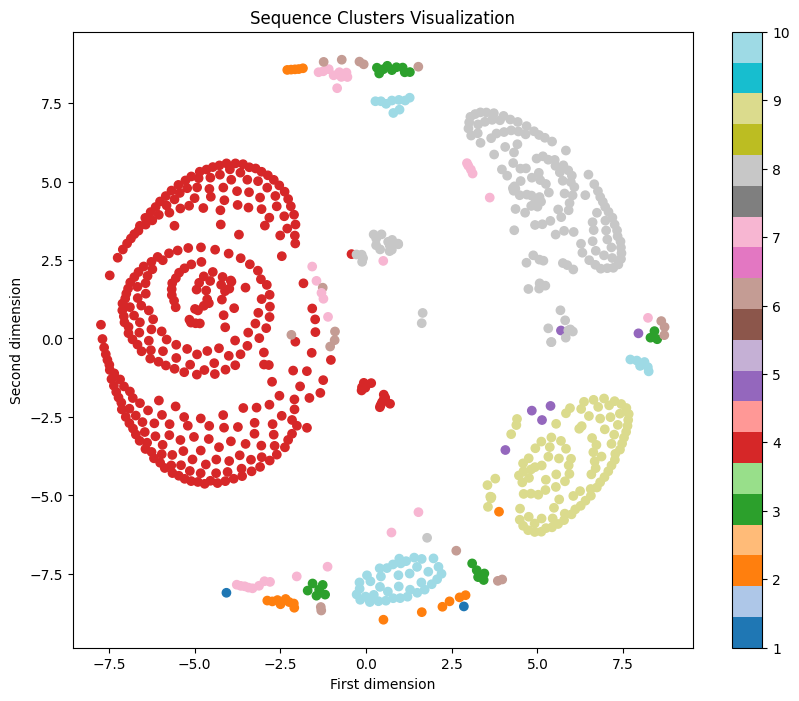

In [54]:
from sklearn.manifold import MDS


def visualize_clusters(sequences: list, clusters: np.ndarray):
    """
    Visualize clusters using MDS for dimensionality reduction
    """
    # Create distance matrix
    dist_matrix = create_distance_matrix(sequences)

    # Use MDS to reduce to 2D
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    coords_2d = mds.fit_transform(dist_matrix)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(coords_2d[:, 0], coords_2d[:, 1], c=clusters, cmap="tab20")
    plt.colorbar(scatter)
    plt.title("Sequence Clusters Visualization")
    plt.xlabel("First dimension")
    plt.ylabel("Second dimension")
    plt.show()


# Visualize the clusters
visualize_clusters(sequences, clusters)

In [70]:
# Print cluster sizes and random sample sequences from each cluster
for cluster_id in np.unique(clusters):
    cluster_sequences = [sequences[i] for i in np.where(clusters == cluster_id)[0]]
    print(f"\nCluster {cluster_id}: {len(cluster_sequences)} sequences")

    # Get sample sequences
    sample_size = min(5, len(cluster_sequences))
    # Use random.sample instead of np.random.choice
    sample_sequences = random.sample(cluster_sequences, sample_size)

    print("Sample sequences:")
    for i, seq in enumerate(sample_sequences, 1):
        print(f"  {i}. {seq}")


Cluster 1: 2 sequences
Sample sequences:
  1. [6, 5]
  2. [5]

Cluster 2: 20 sequences
Sample sequences:
  1. [6, 6]
  2. [7, 6]
  3. [6]
  4. [8, 6, 0, 6, 6, 0, 5]
  5. [6, 6, 0, 6, 0, 7, 0, 7]

Cluster 3: 23 sequences
Sample sequences:
  1. [9, 9, 9, 9]
  2. [9]
  3. [7, 9]
  4. [9]
  5. [9, 9]

Cluster 4: 336 sequences
Sample sequences:
  1. [1]
  2. [1]
  3. [1, 1, 1]
  4. [1]
  5. [1, 1, 1, 0, 1, 0, 1, 1]

Cluster 5: 6 sequences
Sample sequences:
  1. [2, 7, 9, 0, 7]
  2. [1, 4, 0, 7, 0, 7, 0, 9]
  3. [7, 7, 0, 7, 0, 7, 4, 4]
  4. [6, 9, 0, 4, 0, 4]
  5. [7, 1, 1, 4, 0, 7, 0, 2]

Cluster 6: 18 sequences
Sample sequences:
  1. [4, 4, 0, 1]
  2. [4, 4, 0, 1, 0, 1]
  3. [4, 4, 4, 4, 0, 4, 4]
  4. [2, 4]
  5. [7, 4, 4]

Cluster 7: 33 sequences
Sample sequences:
  1. [8]
  2. [8]
  3. [1, 8]
  4. [8]
  5. [8, 8, 0, 9]

Cluster 8: 157 sequences
Sample sequences:
  1. [8, 2, 0, 2, 2]
  2. [3, 2, 0, 2, 9, 9, 0, 9]
  3. [2, 2]
  4. [2, 2, 0, 1]
  5. [3, 2, 0, 2, 0, 2]

Cluster 9: 105 sequ

In [55]:
atc_code_to_num

{'N06AA09': 1,
 'N06AB04': 2,
 'N06AB06': 3,
 'N06AX16': 4,
 'N06AA07': 5,
 'N06AB05': 6,
 'N06AB03': 7,
 'N06AA16': 8,
 'N06AX11': 9}